<a href="https://colab.research.google.com/github/puraminy/mini_proj3/blob/master/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install minisom

#Import Alphabets Dataset

fatal: destination path 'SOM' already exists and is not an empty directory.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((500, 784), (500,), 7, 0)

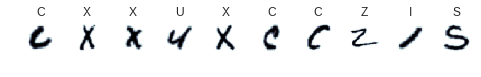

In [9]:
#!git clone "https://github.com/puraminy/mini_proj3"
!git clone "https://github.com/Benyaminhosseiny/SOM"

import numpy as np
alphabet = np.load('SOM/Alphabets.npy')
label = np.load('SOM/Alphabet_labels.npy')
label2 = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z']


import matplotlib.pyplot as plt
idx = np.random.randint(499, size=10)

fig, axes = plt.subplots(1, 10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=None, wspace=0.5)

# for i in range(len(alphabet)):
#   alphabet[i] = alphabet[i] * (255.0 / alphabet[i].max())

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
alphabet = sc.fit_transform(alphabet)
  
pltalpha = alphabet[idx,:]
pltlbl = label[idx]

for i in range(10):
  axes[i].imshow(-1*np.reshape(pltalpha[i,:],[28,28]))
  axes[i].axis('off')
  xlabel = label2[pltlbl[i]]; axes[i].set_title(xlabel)



alphabet.shape, label.shape, max(label), min(label)


/usr/local/lib/python3.6/dist-packages/minisom.py:161: RuntimeWarning: divide by zero encountered in true_divide
  ax = exp(-power(self._neigx-c[0], 2)/d)
/usr/local/lib/python3.6/dist-packages/minisom.py:161: RuntimeWarning: invalid value encountered in true_divide
  ax = exp(-power(self._neigx-c[0], 2)/d)
/usr/local/lib/python3.6/dist-packages/minisom.py:162: RuntimeWarning: divide by zero encountered in true_divide
  ay = exp(-power(self._neigy-c[1], 2)/d)
/usr/local/lib/python3.6/dist-packages/minisom.py:162: RuntimeWarning: invalid value encountered in true_divide
  ay = exp(-power(self._neigy-c[1], 2)/d)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0, 0)
winner= (0

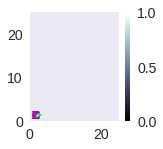

In [19]:
# This code added by Ahmad Pouramini

# print(alphabet[10])

from minisom import MiniSom

som = MiniSom(x=25, y=25, input_len=28*28, sigma=0.0, learning_rate=1.0, neighborhood_function='gaussian')  # initialization of 25x25 SOM
som.random_weights_init(alphabet)  # initialize weights with random values 
som.train_random(alphabet, 300)

plt.figure(figsize=(2, 2))

from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()

for x, t in zip(alphabet, label):  # scatterplot
    w = som.winner(x)
    print("winner=", w)
    plt. text(w[0]+.5,
              w[1]+.5,
              label2[t],
              color=plt.cm.rainbow(t / 7.),
              fontdict={'weight': 'bold',  'size': 11}
              )

/usr/local/lib/python3.6/dist-packages/minisom.py:161: RuntimeWarning: divide by zero encountered in true_divide
  ax = exp(-power(self._neigx-c[0], 2)/d)
/usr/local/lib/python3.6/dist-packages/minisom.py:161: RuntimeWarning: invalid value encountered in true_divide
  ax = exp(-power(self._neigx-c[0], 2)/d)
/usr/local/lib/python3.6/dist-packages/minisom.py:162: RuntimeWarning: divide by zero encountered in true_divide
  ay = exp(-power(self._neigy-c[1], 2)/d)
/usr/local/lib/python3.6/dist-packages/minisom.py:162: RuntimeWarning: invalid value encountered in true_divide
  ay = exp(-power(self._neigy-c[1], 2)/d)
/usr/local/lib/python3.6/dist-packages/minisom.py:235: RuntimeWarning: invalid value encountered in true_divide
  self._weights[it.multi_index] = self._weights[it.multi_index]/norm
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


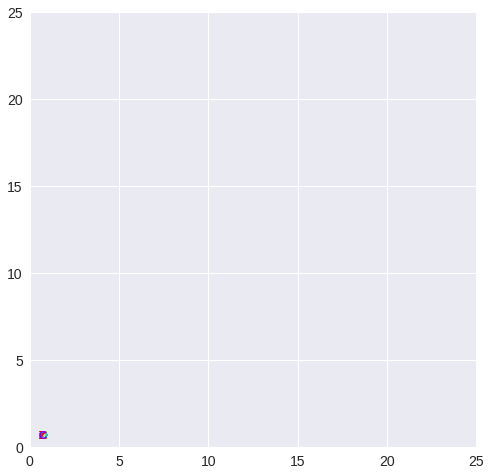

IndexError: ignored

In [17]:
# SOM Training
from minisom import MiniSom

def SOM (data = alphabet, x = 25, y = 25, features = 28*28, radius = 0, learningrate = 1, decay = 0.9, neighborhood='gaussian'):
    #som = MiniSom(x=x, y=y, input_len=features, sigma=radius, learning_rate=learningrate, neighborhood_function=neighborhood)  # initialization of 25x25 SOM
    # som.random_weights_init(alphabet)  # initialize weights with random values
    # initial weights
    weights = np.expand_dims(np.linspace(0, 1, x*y),axis=1)*np.ones([1,features])
    weights = np.reshape(weights, [x, y, features])
    delta_w = 1
    i=0
    while delta_w>0.0001:
        som = MiniSom(x=x, y=y, input_len=features, sigma=0.0, learning_rate=learningrate,
                      neighborhood_function=neighborhood)  # initialization of 25x25 SOM
        som._weights = weights-0
        #weights = som.get_weights() - 0
        som.train_random(data, 1)  # trains the SOM with 1 epoch
        #som.train_batch(data, 1)
        learningrate = decay * learningrate - 0
        delta_w = np.max(np.abs(weights-som._weights))
        weights = som._weights - 0
        i=i+1
    return som, i, delta_w

x = 25; y = 25
features = 28*28
radius = 1
learningrate = 1
decay = 0.95
#neighborhood='mexican_hat'
#neighborhood='bubble'
neighborhood='gaussian'
#neighborhood='triangle'
som,ii,delta_w = SOM (data = alphabet, x = x, y = y, features = features, radius = radius,
                    learningrate = learningrate, decay = decay, neighborhood=neighborhood)
weights = som.get_weights() - 0

# Visualizing Results
if x>1 and y>1:
    plt.figure(figsize=(8, 8))
    wmap = {}
    im = 0
    for x, t in zip(alphabet, label):  # scatterplot
        w = som.winner(x)
        wmap[w] = im
        plt. text(w[0]+.5,
                  w[1]+.5,
                  label2[t],
                  color=plt.cm.rainbow(t / 7.),
                  fontdict={'weight': 'bold',  'size': 11}
                  )
        im = im + 1
    plt.axis([0, weights.shape[0], 0,  weights.shape[1]])
    #plt.savefig('resulting_images/som_digts.png')
    plt.show()


mappings = som.win_map(alphabet)
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)
selected_nodes = sorted_values[-20:] # 20 nodes with the most data

result_mat =np.zeros([20,9])

for i in range(20):
    result_mat[i,8] = len(selected_nodes[i])
    for j in range(len(selected_nodes[i])):
        zeroo = alphabet-selected_nodes[i][j]
        pos = np.where(~zeroo.any(axis=1))[0]
        result_mat[i, label[pos]] = result_mat[i, label[pos]]+1



import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(20), range(9))

aylabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
            '12', '13', '14', '15', '16', '17', '18', '19', '20']
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()

print("Convergence in "+str(ii)+" iterations")